In [1]:
import numpy as np
import pandas as pd
import tools as tls
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [35]:
#####INPUT OF YOUR DAY
import pandas as pd

# 1. Your input variables
wake_up_time = pd.to_datetime("07:30")
completed_useful_time = 1.5
planning_for_gym = True
useful_time = 8
any_plan = True
daily_plan = {
    "meeting": [pd.to_datetime("09:00"), pd.to_datetime("10:00")],
    "lunch":   [pd.to_datetime("12:00"), pd.to_datetime("13:00")],
    "gym":  [pd.to_datetime("18:00"), pd.to_datetime("20:00")]
}

# 2. Convert the dictionary into a list of dictionaries (Rows)
schedule_rows = []
for event_name, times in daily_plan.items():
    schedule_rows.append({
        "event": event_name,
        "start": times[0],
        "end": times[1]
    })

# 3. Create the DataFrame
df = pd.DataFrame(schedule_rows)

# 4. "Broadcast" the single variables to the whole DataFrame
# This repeats the value for every row, making it easy to use in functions
df['wake_up_time'] = wake_up_time
df['completed_useful_time'] = completed_useful_time
df['planning_for_gym'] = planning_for_gym
df['useful_time'] = useful_time
df['any_plan'] = any_plan

print(df)


     event               start                 end        wake_up_time  \
0  meeting 2025-12-23 09:00:00 2025-12-23 10:00:00 2025-12-23 07:30:00   
1    lunch 2025-12-23 12:00:00 2025-12-23 13:00:00 2025-12-23 07:30:00   
2      gym 2025-12-23 18:00:00 2025-12-23 20:00:00 2025-12-23 07:30:00   

   completed_useful_time  planning_for_gym  useful_time  any_plan  
0                    1.5              True            8      True  
1                    1.5              True            8      True  
2                    1.5              True            8      True  


In [42]:
import pandas as pd

def plan_useful_time(df, now=pd.Timestamp.now()):
    """
    Plan useful time slots and return a FULL schedule including fixed events.
    """

    if not isinstance(df, pd.DataFrame):
        return None
    
    wake_up = df['wake_up_time'].unique()[0]
    planning_gym = df['planning_for_gym'].unique()[0]
    total_target_hours = df['useful_time'].unique()[0] - df['completed_useful_time'].unique()[0]
    
    until_sleep = pd.to_timedelta("16:00:00")
    sleep_time = wake_up + until_sleep
    
    # List to hold ALL schedule items (Fixed + Planned)
    full_schedule_list = []

    # A. Add Original Events from DataFrame
    for _, row in df.iterrows():
        full_schedule_list.append({
            "activity": row['event'],
            "start": row['start'],
            "end": row['end'],
            "type": "Fixed Event"
        })

    # B. Add Standard Fixed Blocks (Lunch, Dinner, Gym)
    current_date = wake_up.normalize()
    fixed_blocks = [
        ('Lunch',  current_date + pd.Timedelta("12:00:00"), current_date + pd.Timedelta("13:00:00")),
        ('Dinner', current_date + pd.Timedelta("18:00:00"), current_date + pd.Timedelta("19:00:00")),
        ('Gym',    current_date + pd.Timedelta("20:30:00"), current_date + pd.Timedelta("22:30:00"))
    ]

    existing_event_names = set(df['event'].str.lower().unique())
    
    calc_busy_slots = []
    
    for _, row in df.iterrows():
        calc_busy_slots.append((row['start'], row['end']))

    for name, start, end in fixed_blocks:
        if name.lower() == 'gym' and not planning_gym:
            continue
            
        if name.lower() not in existing_event_names:
            # Add to display list
            full_schedule_list.append({
                "activity": name,
                "start": start,
                "end": end,
                "type": "Fixed Block"
            })
            # Add to calculation list
            calc_busy_slots.append((start, end))

    calc_busy_slots.sort(key=lambda x: x[0])
    
    merged_busy = []
    if calc_busy_slots:
        curr_start, curr_end = calc_busy_slots[0]
        for next_start, next_end in calc_busy_slots[1:]:
            if next_start < curr_end: 
                curr_end = max(curr_end, next_end)
            else:
                merged_busy.append((curr_start, curr_end))
                curr_start, curr_end = next_start, next_end
        merged_busy.append((curr_start, curr_end))

    target_duration = pd.to_timedelta(total_target_hours, unit='h')
    
    # Start scanning from NOW or WAKE_UP
    current_cursor = max(now, wake_up)
    
    # Boundary at sleep time
    merged_busy.append((sleep_time, sleep_time + pd.Timedelta("1h")))

    buffer = pd.Timedelta("00:15:00")

    for busy_start, busy_end in merged_busy:
        if target_duration <= pd.Timedelta(0):
            break
            
        # Ensure the cursor respects the previous event's end + buffer
        
        # Check gap between cursor and next busy slot
        # Effective Gap = (Next Start - Buffer) - Current Cursor
        if busy_start > current_cursor:
            
            # Safe calculation for gap
            gap_end = busy_start - buffer
            gap_duration = gap_end - current_cursor
            
            if gap_duration > pd.Timedelta(0):
                # Use as much of the gap as we need/can
                allocation = min(gap_duration, target_duration)
                
                # Add to Full Schedule
                full_schedule_list.append({
                    "activity": "Useful Work",
                    "start": current_cursor,
                    "end": current_cursor + allocation,
                    "type": "Planned"
                })
                
                # Update remaining target
                target_duration -= allocation
        
        # Move cursor past the busy slot + buffer
        current_cursor = max(current_cursor, busy_end + buffer)

    # Convert to DataFrame
    full_df = pd.DataFrame(full_schedule_list)
    
    # Calculate Duration for display
    full_df['duration'] = full_df['end'] - full_df['start']
    
    # Sort chronologically
    full_df = full_df.sort_values(by='start').reset_index(drop=True)
    
    return full_df, target_duration

# Using a specific test time
schedule, remaining = plan_useful_time(df, now=pd.to_datetime("2025-12-23 08:30"))

print(f"Target Time Left Unplanned: {remaining}")
print(schedule[['start', 'end', 'activity', 'type', 'duration']])
print(f"available time left is {schedule['duration'].sum()}")

Target Time Left Unplanned: 0 days 00:00:00
                start                 end     activity         type  \
0 2025-12-23 08:30:00 2025-12-23 08:45:00  Useful Work      Planned   
1 2025-12-23 09:00:00 2025-12-23 10:00:00      meeting  Fixed Event   
2 2025-12-23 10:15:00 2025-12-23 11:45:00  Useful Work      Planned   
3 2025-12-23 12:00:00 2025-12-23 13:00:00        lunch  Fixed Event   
4 2025-12-23 13:15:00 2025-12-23 17:45:00  Useful Work      Planned   
5 2025-12-23 18:00:00 2025-12-23 20:00:00          gym  Fixed Event   
6 2025-12-23 18:00:00 2025-12-23 19:00:00       Dinner  Fixed Block   
7 2025-12-23 20:15:00 2025-12-23 20:30:00  Useful Work      Planned   

         duration  
0 0 days 00:15:00  
1 0 days 01:00:00  
2 0 days 01:30:00  
3 0 days 01:00:00  
4 0 days 04:30:00  
5 0 days 02:00:00  
6 0 days 01:00:00  
7 0 days 00:15:00  
available time left is 0 days 11:30:00


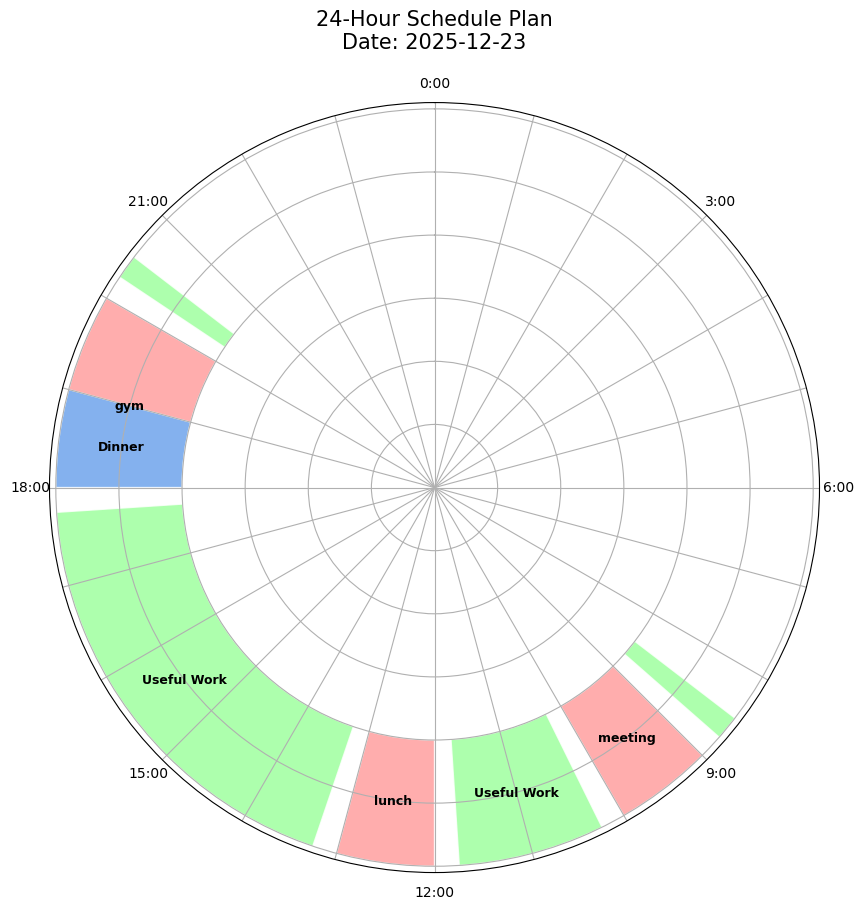

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_schedule_clock(schedule_df):
    if schedule_df is None or schedule_df.empty:
        print("No schedule to plot.")
        return
    
    # Ensure datetime types
    schedule_df['start'] = pd.to_datetime(schedule_df['start'])
    schedule_df['duration'] = pd.to_timedelta(schedule_df['duration'])

    # Calculate Start Time (in hours)
    start_hours = schedule_df['start'].dt.hour + schedule_df['start'].dt.minute / 60
    
    # Calculate Duration (in hours)
    duration_hours = schedule_df['duration'].dt.total_seconds() / 3600


    # 24 Hours = 2*Pi Radians
    # Formula: (Hours / 24) * 2*Pi
    
    theta = (start_hours / 24) * (2 * np.pi)
    width = (duration_hours / 24) * (2 * np.pi)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    
    # Configure as a Clock
    ax.set_theta_zero_location('N')  # 0 is at Top (North)
    ax.set_theta_direction(-1)       # Go Clockwise
    
    # Set Ticks to show actual time (0-23h)
    # We show a tick every 3 hours for cleanliness
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels([f"{h}:00" if h%3==0 else "" for h in range(24)])
    
    color_map = {
        'Fixed Event': '#ff9999',   # Red
        'Fixed Block': '#66b3ff',   # Blue
        'Planned':     '#99ff99',   # Green
    }
    colors = [color_map.get(t, 'gray') for t in schedule_df['type']]

    # bottom=2 creates the "donut hole"
    bars = ax.bar(theta, height=1, width=width, bottom=2, 
                  color=colors, align='edge', edgecolor='white', alpha=0.8)

    for angle, dur, label, type_ in zip(theta, width, schedule_df['activity'], schedule_df['type']):
        # Only label if the slice is big enough to read (e.g., > 30 mins)
        if dur > (0.5/24 * 2*np.pi):
            # Calculate center of the slice
            mid_angle = angle + dur/2
            
            # Distance from center (r)
            r_pos = 2.5 
            
            ax.text(mid_angle, r_pos, label, 
                    ha='center', va='center', rotation_mode='anchor',
                    fontsize=9, fontweight='bold')

    # Remove the Y-axis labels (radial numbers) to look cleaner
    ax.set_yticklabels([])
    ax.set_title(f"24-Hour Schedule Plan\nDate: {schedule_df['start'].iloc[0].date()}", fontsize=15, pad=20)

    plt.show()


plot_schedule_clock(schedule)